In [1]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from keras_metrics import recall, precision

Using TensorFlow backend.


In [11]:
WINDOW_SIZE = 40
TRAIN_TEST_SPLIT = 0.97 # set to 0.1 for other stocks data testing

def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    #dfcopy = df.copy()
    indicators = df.copy()
    indicators['KAMA'] = TA.KAMA(df)
    #indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    #indicators['TEMA20'] = TA.TEMA(df, period=20)
    #indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA40'] = TA.EMA(df, period=40)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    #indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    #indicators['RSI8'] = TA.RSI(df, period=8)
    #indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    #indicators['ATR'] = TA.ATR(df)
    #indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    #indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    
    dft = indicators.close - indicators.close.shift()
    dft.fillna(0, inplace=True)
    dft = dft.values
    signals = np.array([1 if i > 0 else 0 for i in dft])[:]
    dfcopy = indicators.close.values.copy()
    
    for k in ['open', 'high', 'low', 'close', 'volume']: indicators.pop(k)
    dfcopy = np.array([dfcopy[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    data = np.array([
        normalize(indicators[i:i+WINDOW_SIZE].values, axis=0, norm='max')
        for i in range(len(indicators)-WINDOW_SIZE)])
    signals = np.array([signals[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    
    split_index = int(len(data)*TRAIN_TEST_SPLIT)
    data_train, signals_train = data[:split_index], signals[:split_index]
    data_test, signals_test, dfcopy = data[split_index:], signals[split_index:], dfcopy[split_index:]
    return data_train, signals_train, data_test, signals_test, dfcopy

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SPFB2.csv')

In [5]:
conv_size = data_train.shape[-1]
model = Sequential()
#model.add(Dropout(0.1, input_shape=(WINDOW_SIZE, 7)))
model.add(Reshape((WINDOW_SIZE, conv_size, 1), input_shape=(WINDOW_SIZE, conv_size)))
filters = 16
model.add(Conv2D(filters, (1, conv_size), padding='valid'))
model.add(ReLU())
model.add(Dropout(0.3))
model.add(Reshape((WINDOW_SIZE, filters)))
model.add(Conv1D(32, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.2))
model.add(Conv1D(16, kernel_size=3, padding='same'))
model.add(ReLU())
model.add(BatchNormalization())
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=[precision(), recall()])

W0406 21:03:07.981823 24052 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 40, 7, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 1, 16)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 40, 1, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 1, 16)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 40, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 32)            1568      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 38, 32)            0

W0406 21:03:09.451549 24052 deprecation.py:323] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
tf.keras.models.save_model(model, 'newarch.h5')

In [38]:
#model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=[precision(), recall()])
model.fit(data_train, signals_train, shuffle=False, epochs=300, validation_data=(data_test, signals_test))

Train on 17744 samples, validate on 549 samples
Epoch 1/300
17744/17744 [==============================] - 12s 671us/sample - loss: 0.6661 - precision: 0.5864 - recall: 0.6068 - val_loss: 0.7053 - val_precision: 0.4994 - val_recall: 0.7842
Epoch 2/300
17744/17744 [==============================] - 11s 643us/sample - loss: 0.6658 - precision: 0.5868 - recall: 0.6140 - val_loss: 0.7125 - val_precision: 0.4928 - val_recall: 0.7099
Epoch 3/300
17744/17744 [==============================] - 16s 918us/sample - loss: 0.6686 - precision: 0.5846 - recall: 0.6115 - val_loss: 0.7144 - val_precision: 0.4449 - val_recall: 0.3959
Epoch 4/300
17744/17744 [==============================] - 11s 646us/sample - loss: 0.6670 - precision: 0.5873 - recall: 0.6100 - val_loss: 0.7070 - val_precision: 0.5130 - val_recall: 0.8799
Epoch 5/300
17744/17744 [==============================] - 11s 646us/sample - loss: 0.6680 - precision: 0.5860 - recall: 0.6056 - val_loss: 0.7124 - val_precision: 0.3333 - val_recall:

17744/17744 [==============================] - 10s 588us/sample - loss: 0.6632 - precision: 0.5920 - recall: 0.6141 - val_loss: 0.7104 - val_precision: 0.5043 - val_recall: 0.8031
Epoch 86/300
17744/17744 [==============================] - 10s 587us/sample - loss: 0.6638 - precision: 0.5949 - recall: 0.6142 - val_loss: 0.7006 - val_precision: 0.4828 - val_recall: 0.8158
Epoch 87/300
17744/17744 [==============================] - 10s 587us/sample - loss: 0.6635 - precision: 0.5916 - recall: 0.6141 - val_loss: 0.7052 - val_precision: 0.4921 - val_recall: 0.8916
Epoch 88/300
17744/17744 [==============================] - 10s 584us/sample - loss: 0.6661 - precision: 0.5931 - recall: 0.6152 - val_loss: 0.7075 - val_precision: 0.5150 - val_recall: 0.8302
Epoch 89/300
17744/17744 [==============================] - 10s 585us/sample - loss: 0.6643 - precision: 0.5916 - recall: 0.6216 - val_loss: 0.7063 - val_precision: 0.5027 - val_recall: 0.8409
Epoch 90/300
17744/17744 [======================

17744/17744 [==============================] - 11s 640us/sample - loss: 0.6640 - precision: 0.5944 - recall: 0.6208 - val_loss: 0.7111 - val_precision: 0.5309 - val_recall: 0.9248
Epoch 170/300
17744/17744 [==============================] - 11s 639us/sample - loss: 0.6620 - precision: 0.5933 - recall: 0.6148 - val_loss: 0.7116 - val_precision: 0.5042 - val_recall: 0.9712
Epoch 171/300
17744/17744 [==============================] - 11s 644us/sample - loss: 0.6624 - precision: 0.5921 - recall: 0.6127 - val_loss: 0.7091 - val_precision: 0.5227 - val_recall: 0.8303
Epoch 172/300
17744/17744 [==============================] - 11s 645us/sample - loss: 0.6625 - precision: 0.5962 - recall: 0.6150 - val_loss: 0.7074 - val_precision: 0.4805 - val_recall: 0.7663
Epoch 173/300
17744/17744 [==============================] - 11s 648us/sample - loss: 0.6644 - precision: 0.5935 - recall: 0.6132 - val_loss: 0.7048 - val_precision: 0.5089 - val_recall: 0.8436
Epoch 174/300
17744/17744 [=================

17744/17744 [==============================] - 12s 653us/sample - loss: 0.6602 - precision: 0.5956 - recall: 0.6197 - val_loss: 0.7065 - val_precision: 0.5027 - val_recall: 0.9065
Epoch 254/300
17744/17744 [==============================] - 12s 696us/sample - loss: 0.6601 - precision: 0.5983 - recall: 0.6190 - val_loss: 0.7041 - val_precision: 0.4991 - val_recall: 0.9166
Epoch 255/300
17744/17744 [==============================] - 13s 738us/sample - loss: 0.6620 - precision: 0.5936 - recall: 0.6153 - val_loss: 0.7156 - val_precision: 0.5174 - val_recall: 0.9755
Epoch 256/300
17744/17744 [==============================] - 18s 1ms/sample - loss: 0.6598 - precision: 0.5970 - recall: 0.6158 - val_loss: 0.7067 - val_precision: 0.5042 - val_recall: 0.8421
Epoch 257/300
17744/17744 [==============================] - 12s 687us/sample - loss: 0.6608 - precision: 0.5955 - recall: 0.6153 - val_loss: 0.7051 - val_precision: 0.5072 - val_recall: 0.9000
Epoch 258/300
17744/17744 [===================

KeyboardInterrupt: 

In [39]:
SURE = 0.1
COMISSION = 0.05/100
BROKER_COMISSION = 10

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    cur_stocks = 0

    sells = []
    buys = []
    stats = []

    preds = model.predict(data_test)
    temp_df = dfcopy.copy()
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        price = temp_df[i]
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                if cur_stocks > 0:
                    sells.append(i)
                    money -= BROKER_COMISSION
                #n_stocks = money // price
                money += cur_stocks*price*(1-COMISSION)
                cur_stocks = 0
            else:
                n_stocks = money // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                money -= n_stocks*price*(1+COMISSION)
                cur_stocks += n_stocks
        stats.append(price*cur_stocks + money)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)
    
def automated_test(fname, title):
    data_train, signals_train, data_test, signals_test, dfcopy = preprocess(fname)
    model_test(title, data_test, dfcopy)

In [95]:
np.count_nonzero(signals_train) - len(signals_train)

-2060

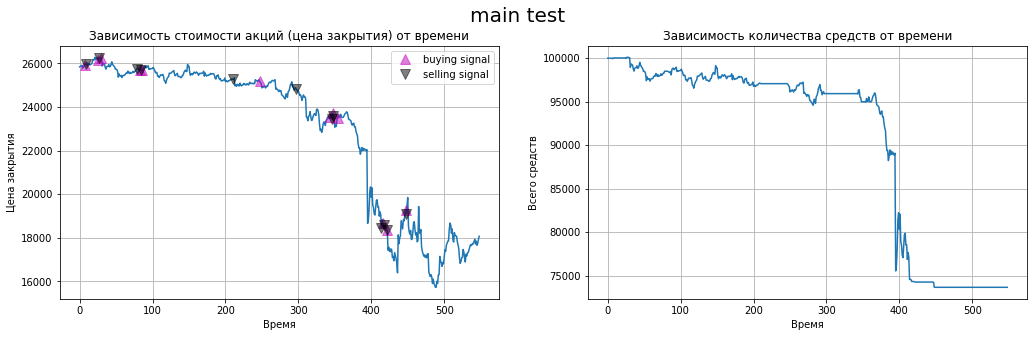

In [40]:
SURE = 0.1
model_test('main test', data_test, dfcopy)

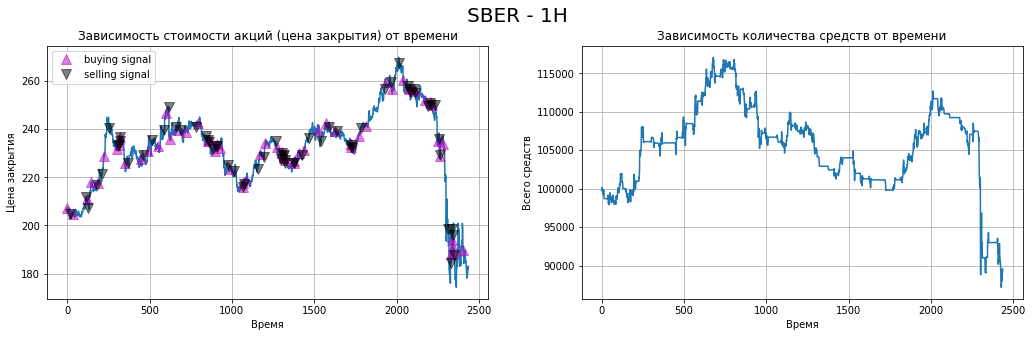

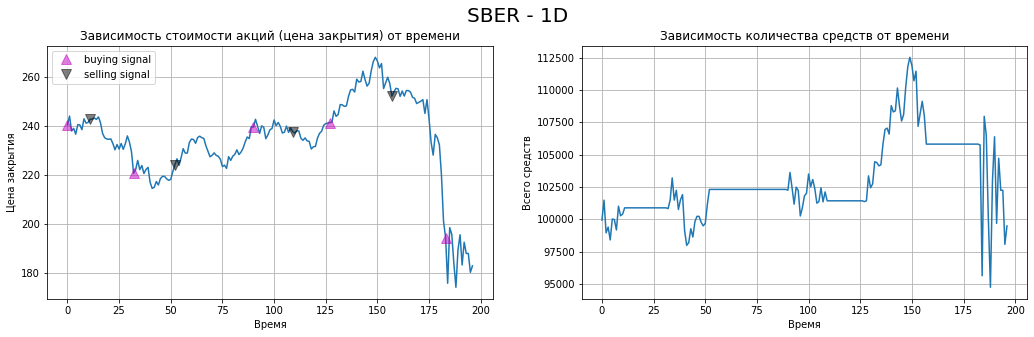

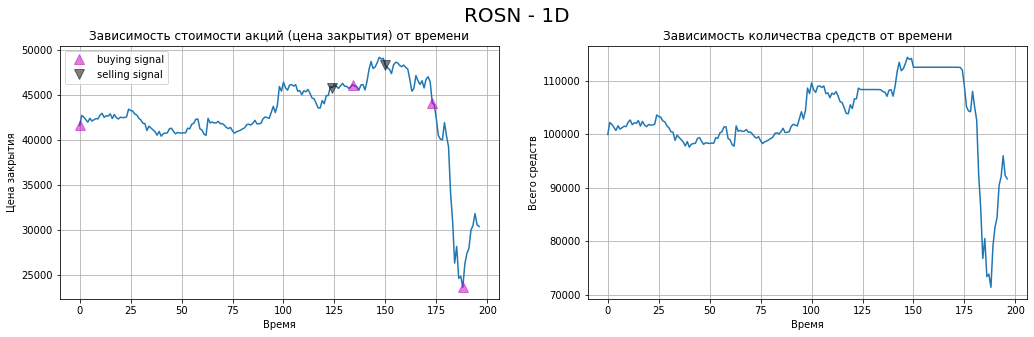

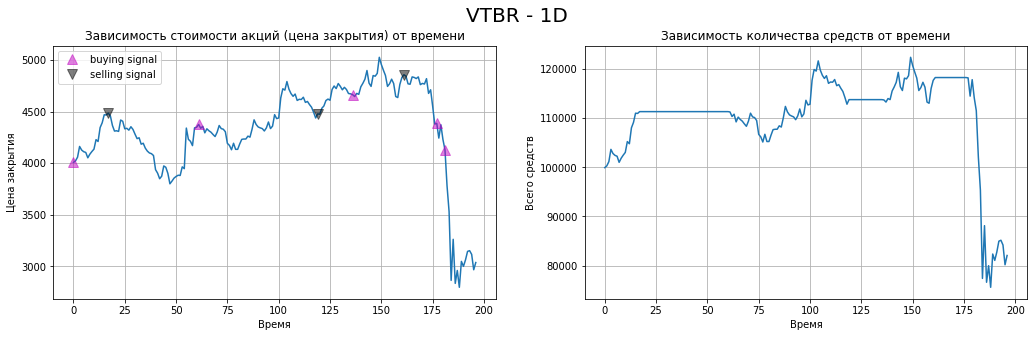

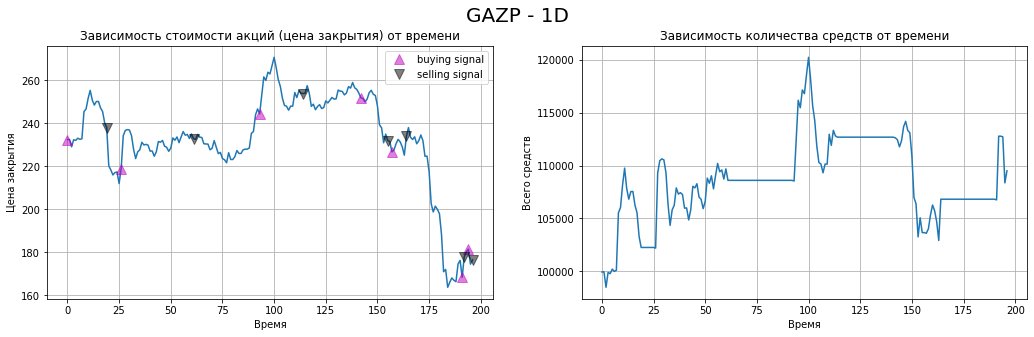

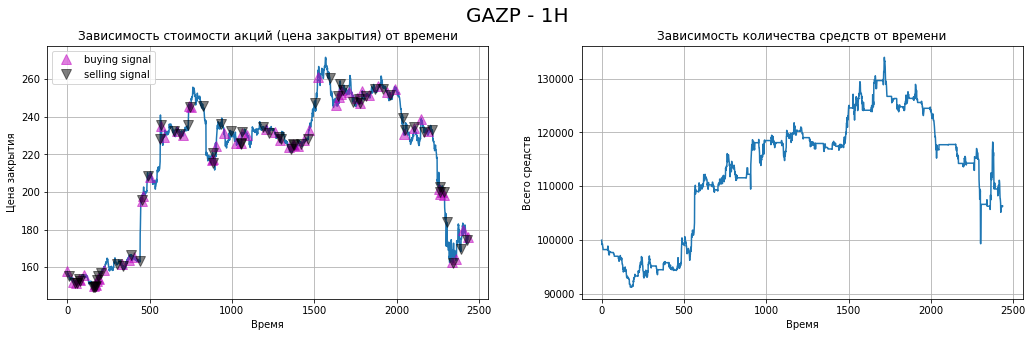

In [47]:
SURE = 0.01
params = [('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          ('GAZPH.csv', 'GAZP - 1H'),
         ]
TRAIN_TEST_SPLIT = 0.1
for p in params:
    automated_test(*p)
TRAIN_TEST_SPLIT = 0.97

In [45]:
preds = model.predict(data_test)

In [46]:
preds

array([[0.48178366],
       [0.46017477],
       [0.27892968],
       [0.43451542],
       [0.4804721 ],
       [0.4632739 ],
       [0.4091761 ],
       [0.639469  ],
       [0.09857947],
       [0.21899295],
       [0.27220124],
       [0.3370316 ],
       [0.3601114 ],
       [0.31758916],
       [0.2917919 ],
       [0.28011936],
       [0.25914392],
       [0.23005688],
       [0.21025759],
       [0.19681105],
       [0.18768683],
       [0.1776025 ],
       [0.17554033],
       [0.20899251],
       [0.270124  ],
       [0.6719488 ],
       [0.28761062],
       [0.30109584],
       [0.27384144],
       [0.63619596],
       [0.4441134 ],
       [0.4699788 ],
       [0.48592395],
       [0.49167347],
       [0.49404845],
       [0.4954569 ],
       [0.4963294 ],
       [0.4974043 ],
       [0.4979981 ],
       [0.4991215 ],
       [0.49925455],
       [0.49962118],
       [0.4995952 ],
       [0.49942705],
       [0.4991182 ],
       [0.49915698],
       [0.49926883],
       [0.499

In [78]:
m = tf.keras.models.load_model('workingfull.h5')

W0406 17:46:00.161276 17672 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0406 17:46:00.176902 17672 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0406 17:46:00.460492 17672 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

In [79]:
m.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 40, 7, 1)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 1, 24)         192       
_________________________________________________________________
re_lu_109 (ReLU)             (None, 40, 1, 24)         0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 40, 1, 24)         0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 40, 24)            0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 38, 32)            2336      
_________________________________________________________________
re_lu_110 (ReLU)             (None, 38, 32)          

In [64]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 24 01:46:38 2017

@author: optimusqp
"""
import urllib


code='POLY';
e='.csv';
market='1'
em='175924';
e='.csv';
p='4';
yf='1990';
yt='2019';
month_start='05';
day_start='20';
month_end='06';
day_end='20';
dtf='1';
tmf='1';
MSOR='1';
mstimever='0'
sep='1';
sep2='3';
datf='5';
at='1';


year_start=yf[2:];
year_end=yt[2:];
mf=(int(month_start.replace('0','')))-1;
mt=(int(month_end.replace('0','')))-1;
df=(int(day_start.replace('0','')))-1;
dt=(int(day_end.replace('0','')))-1;


def quotes(code,year_start,month_start,day_start,year_end,month_end,day_end,e,market,em,df,mf,yf,dt,mt,yt,p,dtf,tmf,MSOR,mstimever,sep,sep2,datf,at):
    
    page = urllib.request.urlopen('http://export.finam.ru/'+str(code)+'_'+str(year_start)+str(month_start)+str(day_start)+'_'+str(year_end)+str(month_end)+str(day_end)+str(e)+'?market='+str(market)+'&em='+str(em)+'&code='+str(code)+'&apply=0&df='+str(df)+'&mf='+str(mf)+'&yf='+str(yf)+'&from='+str(day_start)+'.'+str(month_start)+'.'+str(yf)+'&dt='+str(dt)+'&mt='+str(mt)+'&yt='+str(yt)+'&to='+str(day_end)+'.'+str(month_end)+'.'+str(yt)+'&p='+str(p)+'&f='+str(code)+'_'+str(year_start)+str(month_start)+str(day_start)+'_'+str(year_end)+str(month_end)+str(day_end)+'&e='+str(e)+'&cn='+str(code)+'&dtf='+str(dtf)+'&tmf='+str(tmf)+'&MSOR='+str(MSOR)+'&mstimever='+str(mstimever)+'&sep='+str(sep)+'&sep2='+str(sep2)+'&datf='+str(datf)+'&at='+str(at))
    f = open("company_quotes.csv", "wb")
    content = page.read()
    f.write(content)
    f.close()

qq = quotes(code,year_start,month_start,day_start,year_end,month_end,day_end,e,market,em,df,mf,yf,dt,mt,yt,p,dtf,tmf,MSOR,mstimever,sep,sep2,datf,at)

In [48]:
import requests

In [50]:
r = requests.get("http://export.finam.ru/SPFB.YNDX_900101_200406.csv?market=14&em=175860&code=SPFB.YNDX&apply=0&df=1&mf=0&yf=1990&from=01.01.1990&dt=6&mt=3&yt=2020&to=06.04.2020&p=8&f=SPFB.YNDX_900101_200406&e=.csv&cn=SPFB.YNDX&dtf=4&tmf=3&MSOR=1&mstime=on&mstimever=1&sep=1&sep2=1&datf=5&at=1")

In [51]:
r.__dict__

{'_content': b'',
 '_content_consumed': True,
 '_next': None,
 'status_code': 403,
 'headers': {'Cache-Control': 'private', 'Transfer-Encoding': 'chunked', 'Content-Type': 'text/html', 'Server': 'Microsoft-IIS/8.5', 'Set-Cookie': 'ASPSESSIONIDCQSASTCT=CJJOHINBAILJJMGDMNLMGFGN; path=/', 'X-Powered-By': 'ASP.NET', 'Date': 'Mon, 06 Apr 2020 23:33:56 GMT'},
 'raw': <urllib3.response.HTTPResponse at 0x1dfac59fc18>,
 'url': 'http://export.finam.ru/SPFB.YNDX_900101_200406.csv?market=14&em=175860&code=SPFB.YNDX&apply=0&df=1&mf=0&yf=1990&from=01.01.1990&dt=6&mt=3&yt=2020&to=06.04.2020&p=8&f=SPFB.YNDX_900101_200406&e=.csv&cn=SPFB.YNDX&dtf=4&tmf=3&MSOR=1&mstime=on&mstimever=1&sep=1&sep2=1&datf=5&at=1',
 'encoding': 'ISO-8859-1',
 'history': [],
 'reason': 'forbidden',
 'cookies': <RequestsCookieJar[Cookie(version=0, name='ASPSESSIONIDCQSASTCT', value='CJJOHINBAILJJMGDMNLMGFGN', port=None, port_specified=False, domain='export.finam.ru', domain_specified=False, domain_initial_dot=False, path='/', p

In [3]:
data_test[0]

NameError: name 'data_test' is not defined